In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import glob
import numpy as np
from pathlib import Path
from random import randint
import pandas as pd

In [3]:
import cv2
from fastai import *
from fastai.vision import *

In [4]:
planet = untar_data(URLs.PLANET_TINY)

In [5]:
def _cutout(img, n_holes:int = 5, length:float = 0.05)->Tensor:
    """Randomly mask out one or more patches from an image.
    Args:
        n_holes (int): Number of patches to cut out of each image.
        length (float): The length (in percent of the image size) of each square patch.
    """
    h = img.size(1)
    w = img.size(2)
    patch_width = int(w * length)
    path_height = int(h * length)

    mask = np.ones((h, w), np.float32)

    for n in range(n_holes):
        y = np.random.randint(h)
        x = np.random.randint(w)

        y1 = np.clip(y - path_height // 2, 0, h)
        y2 = np.clip(y + path_height // 2, 0, h)
        x1 = np.clip(x - patch_width // 2, 0, w)
        x2 = np.clip(x + patch_width // 2, 0, w)

        mask[y1: y2, x1: x2] = 0.

    mask = torch.from_numpy(mask)
    mask = mask.expand_as(img)
    return img * mask
cutout = TfmLighting(_cutout)

In [6]:
def _add_image(img, path:str, shape=(15,15))->Tensor:
    h = img.size(1)
    w = img.size(2)

    mask_image = cv2.imread(path)[:, :, [2, 1, 0]] / 255.
    mask_image = cv2.resize(mask_image, shape)
    mask_image = (mask_image - imagenet_stats[0]) / imagenet_stats[1]
    mask_h, mask_w = mask_image.shape[:2]
    mask_image = pil2tensor(mask_image, np.float32)

    x_start = randint(0, w - mask_w)
    y_start = randint(0, h - mask_h)

    img[:, y_start:y_start + mask_h, x_start:x_start + mask_w] = mask_image
    return img

add_image = TfmLighting(_add_image)

In [16]:
help(get_transforms)

Help on function get_transforms in module fastai.vision.transform:

get_transforms(do_flip:bool=True, flip_vert:bool=False, max_rotate:float=10.0, max_zoom:float=1.1, max_lighting:float=0.2, max_warp:float=0.2, p_affine:float=0.75, p_lighting:float=0.75, xtra_tfms:Union[Collection[fastai.vision.image.Transform], NoneType]=None) -> Collection[fastai.vision.image.Transform]
    Utility func to easily create a list of flip, rotate, `zoom`, warp, lighting transforms.



In [13]:
planet_tfms = get_transforms(
    flip_vert=True, 
    max_lighting=0.1, 
    max_zoom=1.05, 
    max_warp=0.,
    p_affine=0.75,
    p_lighting=0.75,  
     xtra_tfms=[add_image(path="Airplane.png")]
) #cutout(n_holes=5, length=0.2)

In [14]:
data = (ImageList.from_csv(planet, 'labels.csv', folder='train', suffix='.jpg')
        .split_by_rand_pct()
        .label_from_df(cols='tags', label_delim=' ')
        .transform(planet_tfms, size=128)
        .databunch()
        .normalize(imagenet_stats))

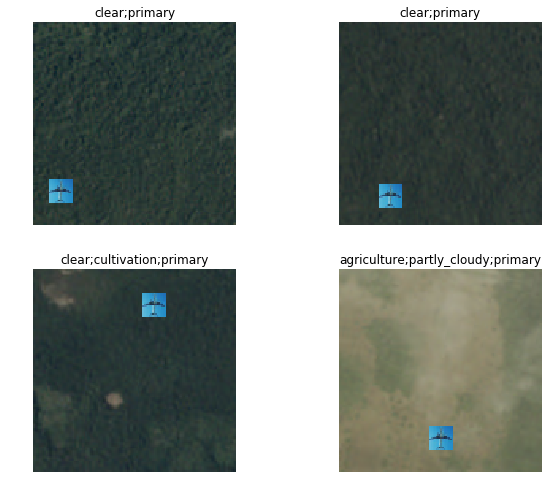

In [15]:
data.show_batch(rows=2, figsize=(9,7))